# 03. Protein Preprocessing and Representation

This notebook processes protein sequences into numerical representations for the GNN model.

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set paths
DATA_DIR = Path('../data')
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'

# Create directories
PROCESSED_DATA.mkdir(exist_ok=True)
(PROCESSED_DATA / 'protein_features').mkdir(exist_ok=True)

## 2. Define Protein Representation Methods

In [2]:
# Amino acid properties for feature encoding
AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
AMINO_ACID_PROPS = {
    # Hydrophobicity index (Kyte-Doolittle scale)
    'hydrophobicity': {
        'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
        'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
        'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
        'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
    },
    # Polarity
    'polarity': {
        'A': 0, 'C': 0, 'D': 1, 'E': 1, 'F': 0,
        'G': 0, 'H': 1, 'I': 0, 'K': 1, 'L': 0,
        'M': 0, 'N': 1, 'P': 0, 'Q': 1, 'R': 1,
        'S': 1, 'T': 1, 'V': 0, 'W': 0, 'Y': 1
    },
    # Molecular weight
    'molecular_weight': {
        'A': 89.1, 'C': 121.2, 'D': 133.1, 'E': 147.1, 'F': 165.2,
        'G': 75.1, 'H': 155.2, 'I': 131.2, 'K': 146.2, 'L': 131.2,
        'M': 149.2, 'N': 132.1, 'P': 115.1, 'Q': 146.2, 'R': 174.2,
        'S': 105.1, 'T': 119.1, 'V': 117.1, 'W': 204.2, 'Y': 181.2
    },
    # pKa (side chain)
    'pka': {
        'A': 0, 'C': 8.3, 'D': 3.9, 'E': 4.2, 'F': 0,
        'G': 0, 'H': 6.0, 'I': 0, 'K': 10.5, 'L': 0,
        'M': 0, 'N': 0, 'P': 0, 'Q': 0, 'R': 12.5,
        'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 10.1
    }
}

In [3]:
class ProteinEncoder:
    """Encode protein sequences using various methods"""
    
    def __init__(self):
        self.amino_acids = AMINO_ACIDS
        self.aa_to_idx = {aa: i for i, aa in enumerate(self.amino_acids)}
        self.properties = AMINO_ACID_PROPS
    
    def one_hot_encode(self, sequence, max_len=None):
        """One-hot encode protein sequence"""
        if max_len is None:
            max_len = len(sequence)
        
        encoding = np.zeros((max_len, 20))
        for i, aa in enumerate(sequence[:max_len]):
            if aa in self.aa_to_idx:
                encoding[i, self.aa_to_idx[aa]] = 1
        return encoding
    
    def property_encode(self, sequence):
        """Encode using physicochemical properties"""
        features = []
        for aa in sequence:
            if aa in self.amino_acids:
                feat = [
                    self.properties['hydrophobicity'][aa] / 4.5,  # Normalize
                    self.properties['polarity'][aa],
                    self.properties['molecular_weight'][aa] / 204.2,  # Normalize by max
                    self.properties['pka'][aa] / 12.5  # Normalize by max
                ]
                features.append(feat)
            else:
                features.append([0, 0, 0, 0])  # Unknown amino acid
        return np.array(features)
    
    def kmer_composition(self, sequence, k=3):
        """Calculate k-mer composition features"""
        kmers = {}
        for i in range(len(sequence) - k + 1):
            kmer = sequence[i:i+k]
            kmers[kmer] = kmers.get(kmer, 0) + 1
        
        # Normalize by sequence length
        total = sum(kmers.values())
        if total > 0:
            for key in kmers:
                kmers[key] = kmers[key] / total
        
        return kmers
    
    def global_descriptors(self, sequence):
        """Calculate global sequence descriptors"""
        if not sequence:
            return np.zeros(10)
        
        # Amino acid composition
        aa_comp = Counter(sequence)
        seq_len = len(sequence)
        
        # Calculate various descriptors
        descriptors = [
            seq_len,  # Length
            sum(self.properties['molecular_weight'].get(aa, 0) for aa in sequence),  # Total MW
            sum(self.properties['hydrophobicity'].get(aa, 0) for aa in sequence) / seq_len,  # Avg hydrophobicity
            sum(self.properties['polarity'].get(aa, 1) for aa in sequence) / seq_len,  # Polarity ratio
            aa_comp.get('C', 0) / seq_len,  # Cysteine ratio (disulfide bonds)
            (aa_comp.get('K', 0) + aa_comp.get('R', 0)) / seq_len,  # Basic residue ratio
            (aa_comp.get('D', 0) + aa_comp.get('E', 0)) / seq_len,  # Acidic residue ratio
            sum(1 for aa in sequence if aa in 'GAVLIPFMW') / seq_len,  # Hydrophobic ratio
            sum(1 for aa in sequence if aa in 'STNQY') / seq_len,  # Polar ratio
            sum(1 for aa in sequence if aa in 'FWY') / seq_len,  # Aromatic ratio
        ]
        
        return np.array(descriptors)

encoder = ProteinEncoder()

## 3. Load Protein Sequences

In [4]:
def load_protein_sequences():
    """Load protein sequences from datasets"""
    proteins = {}
    
    # Load DAVIS proteins
    davis_dir = RAW_DATA / 'davis'
    with open(davis_dir / 'proteins.txt', 'r') as f:
        davis_proteins = json.load(f)
    
    for key, seq in davis_proteins.items():
        proteins[f'davis_{key}'] = seq
    
    # Load KIBA proteins
    kiba_dir = RAW_DATA / 'kiba'
    with open(kiba_dir / 'proteins.txt', 'r') as f:
        kiba_proteins = json.load(f)
    
    for key, seq in kiba_proteins.items():
        proteins[f'kiba_{key}'] = seq
    
    print(f"Loaded {len(davis_proteins)} DAVIS proteins")
    print(f"Loaded {len(kiba_proteins)} KIBA proteins")
    print(f"Total unique proteins: {len(proteins)}")
    
    return proteins, davis_proteins, kiba_proteins

all_proteins, davis_proteins, kiba_proteins = load_protein_sequences()

Loaded 442 DAVIS proteins
Loaded 229 KIBA proteins
Total unique proteins: 671


## 4. Analyze Protein Sequences

/tmp/ipykernel_49349/2562518923.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([davis_lengths, kiba_lengths], labels=['DAVIS', 'KIBA'])


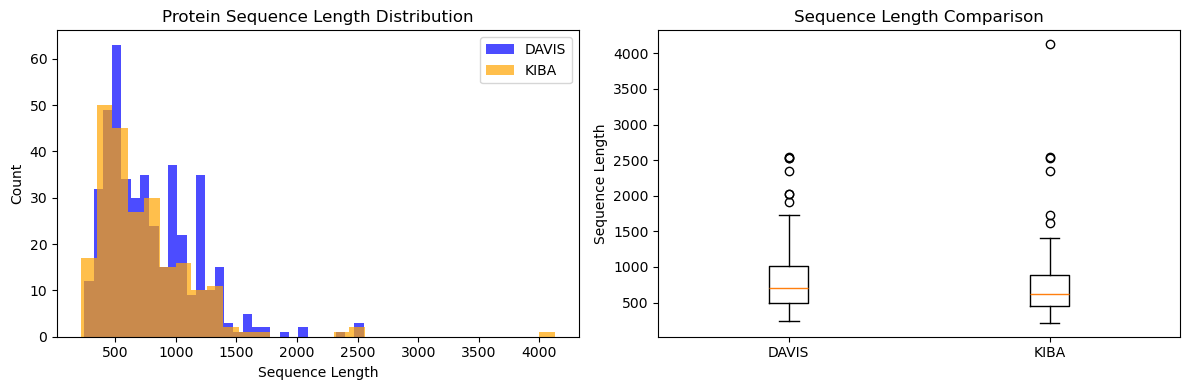

DAVIS - Min: 244, Max: 2549, Mean: 788.9
KIBA - Min: 215, Max: 4128, Mean: 729.0


In [5]:
# Analyze sequence lengths
davis_lengths = [len(seq) for seq in davis_proteins.values()]
kiba_lengths = [len(seq) for seq in kiba_proteins.values()]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(davis_lengths, bins=30, alpha=0.7, color='blue', label='DAVIS')
axes[0].hist(kiba_lengths, bins=30, alpha=0.7, color='orange', label='KIBA')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Count')
axes[0].set_title('Protein Sequence Length Distribution')
axes[0].legend()

# Box plot comparison
axes[1].boxplot([davis_lengths, kiba_lengths], labels=['DAVIS', 'KIBA'])
axes[1].set_ylabel('Sequence Length')
axes[1].set_title('Sequence Length Comparison')

plt.tight_layout()
plt.show()

print(f"DAVIS - Min: {min(davis_lengths)}, Max: {max(davis_lengths)}, Mean: {np.mean(davis_lengths):.1f}")
print(f"KIBA - Min: {min(kiba_lengths)}, Max: {max(kiba_lengths)}, Mean: {np.mean(kiba_lengths):.1f}")

## 5. Generate Protein Features

In [ ]:
def process_protein_features(proteins, encoder, max_seq_len=1200):
    """Generate multiple feature representations for proteins"""
    features = {}
    
    for protein_id, sequence in tqdm(proteins.items(), desc="Processing proteins"):
        # Truncate very long sequences
        if len(sequence) > max_seq_len:
            sequence = sequence[:max_seq_len]
        
        features[protein_id] = {
            'sequence': sequence,
            'length': len(sequence),
            'one_hot': encoder.one_hot_encode(sequence, max_seq_len),
            'properties': encoder.property_encode(sequence),
            'global_desc': encoder.global_descriptors(sequence),
            'kmer_3': encoder.kmer_composition(sequence, k=3),
            'kmer_4': encoder.kmer_composition(sequence, k=4)
        }
    
    return features

# Process DAVIS proteins
print("Processing DAVIS proteins...")
davis_features = process_protein_features(
    {k: v for k, v in davis_proteins.items()}, 
    encoder
)

# Process KIBA proteins
print("Processing KIBA proteins...")
kiba_features = process_protein_features(
    {k: v for k, v in kiba_proteins.items()}, 
    encoder
)

## 6. CNN-based Protein Embedding

In [ ]:
class ProteinCNN(nn.Module):
    """1D CNN for protein sequence embedding"""
    def __init__(self, vocab_size=20, embedding_dim=128, num_filters=64, filter_sizes=[3, 5, 7]):
        super(ProteinCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)  # +1 for padding
        
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, 256)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        x = x.transpose(1, 2)  # (batch_size, embedding_dim, seq_len)
        
        # Apply convolutions
        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(x))  # (batch_size, num_filters, new_seq_len)
            pooled = torch.max(conv_out, dim=2)[0]  # Global max pooling
            conv_outputs.append(pooled)
        
        # Concatenate all conv outputs
        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Initialize protein CNN model
protein_cnn = ProteinCNN()
print(f"Protein CNN model parameters: {sum(p.numel() for p in protein_cnn.parameters()):,}")

## 7. Create Fixed-Length Protein Representations

In [ ]:
def create_fixed_representations(features_dict, max_len=1200):
    """Create fixed-length representations for all proteins"""
    fixed_features = {}
    
    for protein_id, features in features_dict.items():
        # Use global descriptors as the fixed representation
        # You can also use CNN embeddings or other methods
        fixed_features[protein_id] = features['global_desc']
    
    return fixed_features

# Create fixed representations
davis_fixed = create_fixed_representations(davis_features)
kiba_fixed = create_fixed_representations(kiba_features)

print(f"DAVIS fixed features shape: {next(iter(davis_fixed.values())).shape}")
print(f"KIBA fixed features shape: {next(iter(kiba_fixed.values())).shape}")

## 8. Visualize Protein Feature Space

In [ ]:
# Combine all protein features
all_fixed_features = []
all_labels = []

for protein_id, features in davis_fixed.items():
    all_fixed_features.append(features)
    all_labels.append('DAVIS')

for protein_id, features in kiba_fixed.items():
    all_fixed_features.append(features)
    all_labels.append('KIBA')

all_fixed_features = np.array(all_fixed_features)

# PCA visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(all_fixed_features)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for label in ['DAVIS', 'KIBA']:
    mask = np.array(all_labels) == label
    ax.scatter(pca_features[mask, 0], pca_features[mask, 1], 
              label=label, alpha=0.6, s=30)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax.set_title('Protein Feature Space (PCA)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

## 9. Save Processed Protein Features

In [ ]:
# Save protein features
protein_features_dir = PROCESSED_DATA / 'protein_features'

# Save DAVIS features
with open(protein_features_dir / 'davis_protein_features.pkl', 'wb') as f:
    pickle.dump(davis_features, f)

with open(protein_features_dir / 'davis_protein_fixed.pkl', 'wb') as f:
    pickle.dump(davis_fixed, f)

# Save KIBA features
with open(protein_features_dir / 'kiba_protein_features.pkl', 'wb') as f:
    pickle.dump(kiba_features, f)

with open(protein_features_dir / 'kiba_protein_fixed.pkl', 'wb') as f:
    pickle.dump(kiba_fixed, f)

# Save encoder for later use
with open(protein_features_dir / 'protein_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("✓ Protein features saved successfully")
print(f"  - DAVIS features: {len(davis_features)} proteins")
print(f"  - KIBA features: {len(kiba_features)} proteins")
print(f"  - Feature dimension: {next(iter(davis_fixed.values())).shape[0]}")

## 10. Summary

In [ ]:
print("\n" + "="*50)
print("PROTEIN PREPROCESSING COMPLETE")
print("="*50)
print(f"\nProcessed proteins:")
print(f"  - DAVIS: {len(davis_features)} proteins")
print(f"  - KIBA: {len(kiba_features)} proteins")
print(f"\nFeature representations created:")
print(f"  - One-hot encoding (1200 × 20)")
print(f"  - Property encoding (seq_len × 4)")
print(f"  - Global descriptors (10 features)")
print(f"  - K-mer composition (3-mer and 4-mer)")
print(f"\nFiles saved:")
print(f"  - data/processed/protein_features/davis_protein_features.pkl")
print(f"  - data/processed/protein_features/kiba_protein_features.pkl")
print(f"\nNext step: Train DTI model in notebook 04")